### Data Importation

In [2]:
import pandas as pd
train_df = pd.read_csv('/content/train_dataset.csv')
test_df = pd.read_csv('/content/test_dataset.csv')
validation_df = pd.read_csv('/content/valid_dataset.csv')

In [2]:
train_df.columns

Index(['text', 'anger', 'anticipation', 'disgust', 'fear', 'joy', 'love',
       'optimism', 'pessimism', 'sadness', 'surprise', 'trust'],
      dtype='object')

### **Data preparation**

In [3]:
import numpy as np
MAX_LENGTH = 64
X_train_input_ids = np.zeros((len(train_df), MAX_LENGTH))
X_train_attn_masks = np.zeros((len(train_df), MAX_LENGTH))

X_test_input_ids = np.zeros((len(test_df), MAX_LENGTH))
X_test_attn_masks = np.zeros((len(test_df), MAX_LENGTH))

X_validation_input_ids = np.zeros((len(validation_df), MAX_LENGTH))
X_validation_attn_masks = np.zeros((len(validation_df), MAX_LENGTH))

In [4]:
from tqdm import tqdm

def generate_data(df, ids, masks, tokenizer):
    for i, text in tqdm(enumerate(df['text'])):
        tokenized_text = tokenizer.encode_plus(
            text,
            max_length=MAX_LENGTH, 
            truncation=True, 
            padding='max_length', 
            add_special_tokens=True,
            return_tensors='tf'
        )
        ids[i, :] = tokenized_text.input_ids
        masks[i, :] = tokenized_text.attention_mask
    return ids, masks

In [5]:
!pip install transformers -q
from transformers import BertTokenizerFast
tokenizer = BertTokenizerFast.from_pretrained("aubmindlab/bert-large-arabertv02-twitter")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 27.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 63.0 MB/s eta 0:00:00


In [6]:
X_train_input_ids, X_train_attn_masks = generate_data(train_df, X_train_input_ids, X_train_attn_masks, tokenizer) 

X_test_input_ids, X_test_attn_masks = generate_data(test_df, X_test_input_ids, X_test_attn_masks, tokenizer) 

X_validation_input_ids, X_validation_attn_masks = generate_data(validation_df, X_validation_input_ids, X_validation_attn_masks, tokenizer) 

2257it [00:07, 294.09it/s] 
1507it [00:00, 1541.50it/s]
580it [00:00, 1333.51it/s]


In [7]:
X_train_input_ids

array([[2.0000e+00, 1.8440e+03, 8.8000e+02, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [2.0000e+00, 4.5900e+02, 2.4276e+04, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [2.0000e+00, 2.9031e+04, 2.7083e+04, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       ...,
       [2.0000e+00, 1.9550e+03, 7.2410e+03, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [2.0000e+00, 2.2949e+04, 6.6900e+02, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [2.0000e+00, 1.6038e+04, 2.0900e+02, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00]])

In [7]:
train_labels = np.zeros((len(train_df), 11))
test_labels = np.zeros((len(test_df), 11))
validation_labels = np.zeros((len(validation_df), 11))

In [8]:
labels_names = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust']  
train_labels = train_df[labels_names].values.astype('int8')
test_labels = test_df[labels_names].values.astype('int8')
validation_labels = validation_df[labels_names].values.astype('int8')

In [10]:
train_labels

array([[1, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 1, 0, 0]], dtype=int8)

In [9]:
import tensorflow as tf
# creating a data pipeline using tensorflow dataset utility, creates batches of data for easy loading...
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_input_ids, X_train_attn_masks, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test_input_ids, X_test_attn_masks, test_labels))
validation_dataset = tf.data.Dataset.from_tensor_slices((X_validation_input_ids, X_validation_attn_masks, validation_labels))

In [10]:
def SentimentDatasetMapFunction(input_ids, attn_masks, labels):
    return {
        'input_ids': input_ids,
        'attention_mask': attn_masks
    }, labels

In [11]:
BATCH_SIZE = 32
train_dataset = train_dataset.map(SentimentDatasetMapFunction) # converting to required format for tensorflow dataset 
train_dataset = train_dataset.shuffle(10000).batch(BATCH_SIZE, drop_remainder=True) # batch size, drop any left out tensor
validation_dataset = validation_dataset.map(SentimentDatasetMapFunction)
validation_dataset = validation_dataset.shuffle(10000).batch(BATCH_SIZE, drop_remainder=True)
test_dataset = test_dataset.map(SentimentDatasetMapFunction)
test_dataset = test_dataset.shuffle(10000).batch(BATCH_SIZE, drop_remainder=False)

### **Model**

In [12]:
from transformers import TFBertModel
model = TFBertModel.from_pretrained("aubmindlab/bert-large-arabertv02-twitter", from_pt=True) # bert base model with pretrained weights

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'bert.embeddings.position_ids']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFBertModel were not initialized from the PyTorch model and are newly initialized: ['bert.pooler.dense.weight', 'bert.p

In [13]:
# defining 2 input layers for input_ids and attn_masks
input_ids = tf.keras.layers.Input(shape=(MAX_LENGTH,), name='input_ids', dtype='int32')
attn_masks = tf.keras.layers.Input(shape=(MAX_LENGTH,), name='attention_mask', dtype='int32')

In [14]:
bert_embds = model.bert(input_ids, attention_mask=attn_masks)[1] # 0 -> activation layer (3D), 1 -> pooled output layer (2D)
# base = model.bert(input_ids, attention_mask=attn_masks)
# bert_embds = base.pooler_output

In [15]:
intermediate_layer = tf.keras.layers.Dense(64, activation='relu', name='intermediate_layer')(bert_embds)
output_layer = tf.keras.layers.Dense(11, activation='sigmoid', name='output_layer')(intermediate_layer) # softmax -> calcs probs of classes

In [16]:
emotion_model = tf.keras.Model(inputs=[input_ids, attn_masks], outputs=output_layer)
emotion_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 64)]         0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 64)]         0           []                               
                                                                                                  
 bert (TFBertMainLayer)         TFBaseModelOutputWi  369423360   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 64,                                            

### **Train**

Without scheduler

In [17]:
optim = tf.keras.optimizers.Adam(learning_rate=2e-5) # 1e-3
loss_func = tf.keras.losses.BinaryCrossentropy()
acc = tf.keras.metrics.BinaryAccuracy('BinaryAccuracy')

In [18]:
emotion_model.compile(optimizer=optim, loss=loss_func, metrics=[acc])

wit early stopping

In [19]:
NUM_EPOCHS = 20

# Define the early stopping callback
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

with tf.device('/GPU:0'):
  history = emotion_model.fit(
      train_dataset,
      validation_data=validation_dataset,
      epochs=NUM_EPOCHS,
      callbacks=[early_stopping_callback]
  )

Epoch 1/20
70/70 [==============================] - 179s 1s/step - loss: 0.4099 - BinaryAccuracy: 0.8273 - val_loss: 0.3208 - val_BinaryAccuracy: 0.8695
Epoch 2/20
70/70 [==============================] - 94s 1s/step - loss: 0.2761 - BinaryAccuracy: 0.8900 - val_loss: 0.2842 - val_BinaryAccuracy: 0.8824
Epoch 3/20
70/70 [==============================] - 95s 1s/step - loss: 0.2275 - BinaryAccuracy: 0.9092 - val_loss: 0.2704 - val_BinaryAccuracy: 0.8868
Epoch 4/20
70/70 [==============================] - 94s 1s/step - loss: 0.1942 - BinaryAccuracy: 0.9249 - val_loss: 0.2681 - val_BinaryAccuracy: 0.8898
Epoch 5/20
70/70 [==============================] - 95s 1s/step - loss: 0.1646 - BinaryAccuracy: 0.9399 - val_loss: 0.2760 - val_BinaryAccuracy: 0.8849
Epoch 6/20
70/70 [==============================] - 95s 1s/step - loss: 0.1376 - BinaryAccuracy: 0.9512 - val_loss: 0.2774 - val_BinaryAccuracy: 0.8897
Epoch 7/20
70/70 [==============================] - 95s 1s/step - loss: 0.1115 - Binary

In [20]:
from sklearn.metrics import jaccard_score

# Generate predictions on test set
test_preds = emotion_model.predict([X_test_input_ids, X_test_attn_masks])
test_preds[test_preds >= 0.5] = 1
test_preds[test_preds < 0.5] = 0

48/48 [==============================] - 28s 434ms/step


In [21]:
# Compute Jaccard index
jaccard_index = jaccard_score(test_labels, test_preds, average='weighted')

print('Jaccard index:', jaccard_index)

Jaccard index: 0.5557280420836991


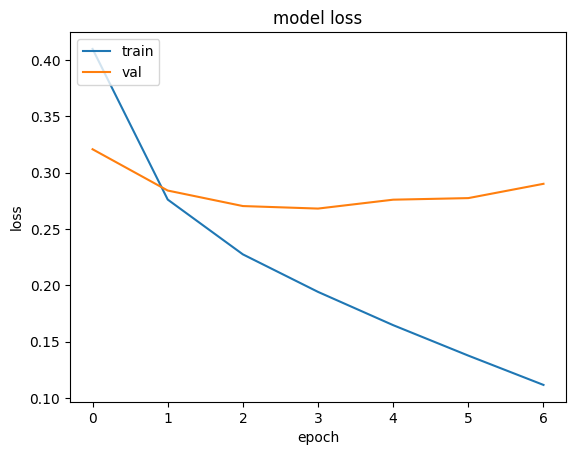

In [22]:
from matplotlib import pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()